In [430]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial

In [586]:
sampling = 0.02

plt.rcParams['figure.figsize'] = [10, 13]
plt.rcParams['figure.dpi'] = 100

x = np.arange(-4, 4, sampling)

In [587]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    samplingFreq = 1/sampling
    return np.arange(-samplingFreq/2, samplingFreq/2, samplingFreq/len(x))
def flipAtOrigin(data):
    tmp = np.split(data, 2)
    return np.concatenate([tmp[1], tmp[0]])

In [588]:
#apply givven filter to given FT
#data - array float, size [N]
#filt - array float, size [N]
def applyFilter(data, filt):
    tmp = np.split(data, 2)
    fs = np.concatenate([tmp[1], tmp[0]])
    fs = fs * filt
    tmp = np.split(fs, 2)
    return np.concatenate([tmp[1], tmp[0]])

In [589]:
def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [590]:
def sin3(x):
    return np.sin(2*np.pi*x)+np.sin(2*np.pi*3*x)*0.2+np.sin(2*np.pi*6*x)*0.2

In [591]:
def lowPassFilter(w, x):
    return np.exp(1j*np.pi/(2*w)*x) if np.abs(x) < w else 0

def highPassFilter(w, x):
    return 0 if np.abs(x) < w else np.exp(1j*np.pi/(2*w)*x)

In [592]:
def rollingAverage (data, radius = 5):
    out = np.zeros(len(data))
    for i in range(len(data)):
        count = 0
        sum_val = 0
        for j in range(-radius, radius):
            count+=1
            sum_val += data[i+j] if 0 <= i+j < len(data)  else 0
        out[i] = sum_val/count
    return out

In [593]:
def plotFreq(axs, data, label = None, color = 'red'):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    freqAxis = freqAxis[:len(freqAxis)//2]
    axs.plot(freqAxis, np.abs(np.split(data, 2)[0]), label = label, color = color)

In [601]:
def test(f, filt):
    fig, axs = plt.subplots(7)
    data = FFT(np.vectorize(f)(x))#функция
    
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    halfFreqAxis = freqAxis[:len(freqAxis)//2]
    
    pid = 0
    plotFreq(axs[pid], data, label="спектр f", color = 'green')
    axs[pid].grid()
    axs[pid].legend()
    pid+=1
    
    filterData = np.vectorize(filt, otypes=[np.complex128])(freqAxis)
    fil = flipAtOrigin(filterData)
    fil = np.fft.ifft(filterData)
    fil = flipAtOrigin(fil)
    
    axs[pid].plot(halfFreqAxis, np.abs(filterData[:len(filterData)//2]), label = "фурье ид. фильтра (abs)")
    axs[pid].grid()
    axs[pid].legend()    
    pid += 1

    axs[pid].plot(x, np.abs(fil), label = "ид. фильтр")
    axs[pid].grid()
    axs[pid].legend()  
    pid += 1
    
    r_fil = rollingAverage(np.vectorize(partial(rect, 1.0))(x), 20)*fil
    
    axs[pid].plot(x, np.abs(r_fil), label = "re. фильтр", color = 'red')
    axs[pid].grid()
    axs[pid].legend()  
    pid += 1
    
    f_r_fil = np.fft.fft(r_fil)
    axs[pid].plot(halfFreqAxis, np.abs(f_r_fil[:len(f_r_fil)//2]), label = "фурье re. фильтра", color = 'red')
    axs[pid].grid()
    axs[pid].legend()  
    pid += 1
    
    r_filtered = np.convolve(r_fil, np.vectorize(f)(x), 'same')
    
    axs[pid].plot(x, np.real(r_filtered), label = "после re. фильтра", color = 'red')
    axs[pid].plot(x, np.real(np.vectorize(f)(x)), label = "до фильтра")
    axs[pid].grid()
    axs[pid].legend()  
    pid += 1
    
    filtered = np.convolve(fil, np.vectorize(f)(x), 'same')
    axs[pid].plot(x, np.real(filtered), label = "после perf. фильтра", color = 'red')
    axs[pid].plot(x, np.real(np.vectorize(f)(x)), label = "до фильтра")
    axs[pid].grid()
    axs[pid].legend()  
    pid += 1

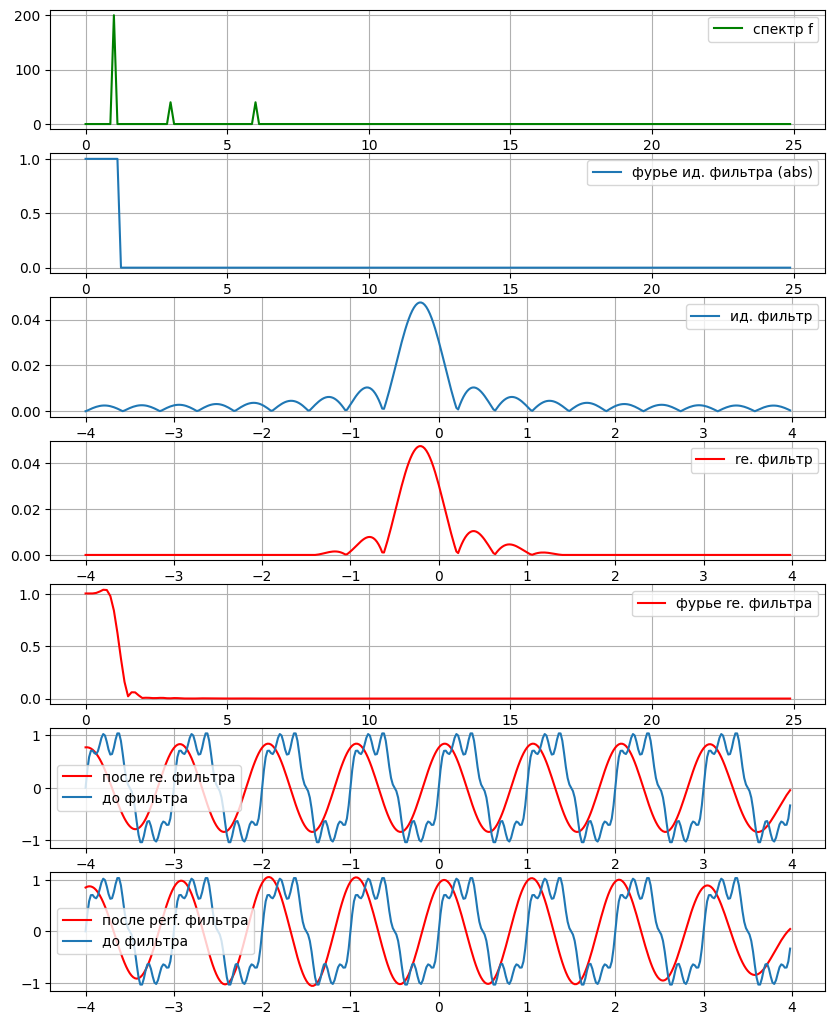

In [602]:
test(sin3, partial(lowPassFilter, 1.2))

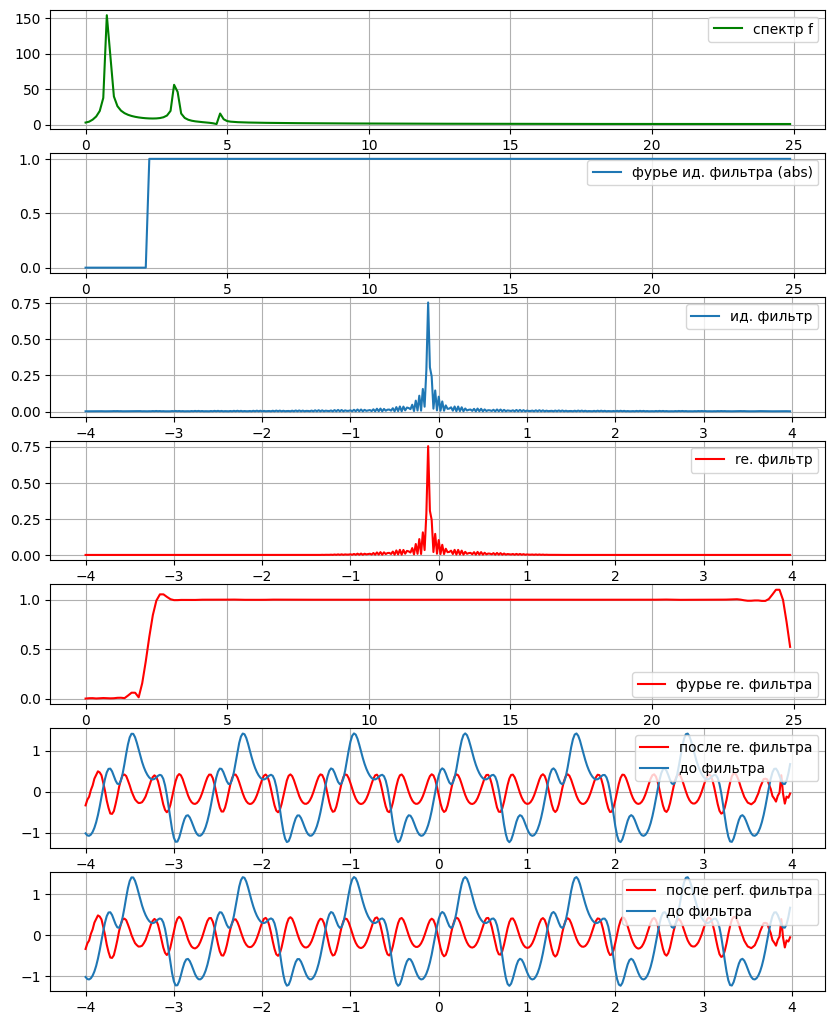

In [603]:
test(sin4, partial(highPassFilter, 2.2))